In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Load the data:

In [3]:
import kagglehub

In [4]:
path = kagglehub.dataset_download("bittlingmayer/amazonreviews")
print("Path to dataset files:", path)

Path to dataset files: /Users/zakaria/.cache/kagglehub/datasets/bittlingmayer/amazonreviews/versions/7


In [5]:
# --> This contains two text files: 'train.ft.txt.bz2'(464.3MB) and 'test.ft.txt.bz2'(52.7MB)
# --> To be extracted first to: 'train.ft.txt' and 'test.ft.txt'

In [6]:
import regex as re
import bz2

In [7]:
def get_labels_and_texts(file):
    labels = []
    texts = []
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        texts.append(x[10:].strip())
    return np.array(labels), texts

In [8]:
train_labels, train_texts = get_labels_and_texts(f'{path}/train.ft.txt.bz2')
test_labels, test_texts = get_labels_and_texts(f'{path}/test.ft.txt.bz2')

In [9]:
train_labels[0]

np.int64(1)

In [10]:
train_texts[0]

'Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [11]:
len(train_labels)

3600000

In [12]:
len(train_texts)

3600000

In [13]:
train_df = pd.DataFrame({'text':train_texts, 'label':train_labels})
test_df = pd.DataFrame({'text':test_texts, 'label':test_labels})

In [14]:
train_df.head()

,text,label
0,Stuning even for the non-gamer: This sound tra...,1
1,The best soundtrack ever to anything.: I'm rea...,1
2,Amazing!: This soundtrack is my favorite music...,1
3,Excellent Soundtrack: I truly like this soundt...,1
4,"Remember, Pull Your Jaw Off The Floor After He...",1


In [15]:
test_df.head()

,text,label
0,Great CD: My lovely Pat has one of the GREAT v...,1
1,One of the best game music soundtracks - for a...,1
2,Batteries died within a year ...: I bought thi...,0
3,"works fine, but Maha Energy is better: Check o...",1
4,Great for the non-audiophile: Reviewed quite a...,1


In [16]:
train_df = train_df.head(8000)
test_df = test_df.head(2000)

## Data Preprocessing:

In [18]:
print(train_df.shape)
print(test_df.shape)

(8000, 2)
(2000, 2)


In [19]:
# Remove duplicates(if they exist) with the same  and keep only the first duplicate:
train_df.drop_duplicates(subset=['text'],keep='first',inplace=True)
test_df.drop_duplicates(subset=['text'],keep='first',inplace=True)

In [20]:
print(train_df.shape)
print(test_df.shape)

(8000, 2)
(2000, 2)


<Axes: xlabel='label', ylabel='count'>

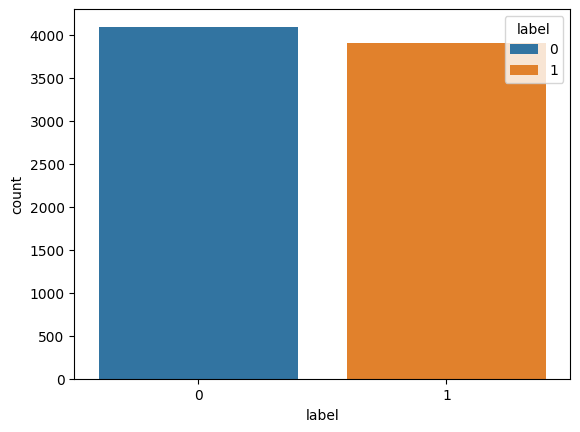

In [21]:
# Quick EDA:
sns.countplot(data=train_df, x='label', hue='label')

In [22]:
## Cleaning the data:
def preprocess_text(text):
    # convert it to strings
    text = str(text)
    
    # lower the text
    text = text.lower()

    # replace everything doesn't match a lowercase or a space with ''(means: removing it)
    text = re.sub(r'[^a-z\s]', '', text)

    # remove multiple spaces
    text = ' '.join(text.split())
    
    return text

In [23]:
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)

In [24]:
print("Original:", train_df['text'].iloc[0][:100])
print("\nCleaned:", train_df['cleaned_text'].iloc[0][:100])

Original: Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so

Cleaned: stuning even for the nongamer this sound track was beautiful it paints the senery in your mind so we


## Prepare data for medeling:

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence

In [29]:
# Initialize and fit
MAX_FEATURES = 10000
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_texts)

# Convert to sequences
train_texts = tokenizer.texts_to_sequences(train_texts)
val_texts = tokenizer.texts_to_sequences(val_texts)
test_texts = tokenizer.texts_to_sequences(test_texts)

In [30]:
### >> Padding Sequences(if you want to):
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [31]:
MAX_LENGTH = max(len(train_ex) for train_ex in train_texts)
train_texts = pad_sequences(train_texts, maxlen=MAX_LENGTH)
val_texts = pad_sequences(val_texts, maxlen=MAX_LENGTH)
test_texts = pad_sequences(test_texts, maxlen=MAX_LENGTH)

## Convolutional Neural Network Model:

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [66]:
def build_model():
    embedding_dim = 100

    model = Sequential([
        # Embedding layer outputs 3D: (batch_size, max_length, embedding_dim)
        Embedding(MAX_FEATURES, embedding_dim, input_length=MAX_LENGTH),
        
        # Conv1D expects 3D input: (batch_size, sequence_length, features)
        Conv1D(128, 5, activation='relu'),
        BatchNormalization(),
        GlobalMaxPooling1D(),  # This reduces to 2D: (batch_size, features)
        Dropout(0.5),
        
        # After GlobalMaxPooling1D, we have 2D data, so use Dense layers
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        Dropout(0.2),
        
        Dense(1, activation='sigmoid')
    ])

    # Explicitly build the model(To show the values in model.summary())
    model.build(input_shape=(None, MAX_LENGTH))
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy', 'precision', 'recall']
    )
    
    return model
    
model = build_model()

/opt/anaconda3/envs/py3-TF2.0/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [68]:
# Model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_5          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [74]:
# Train the model
history = model.fit(
    train_texts,
    train_labels,
    validation_data=(val_texts, val_labels),
    epochs=2,
    batch_size=128,
    verbose=1
)

Epoch 1/2
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 1647s 73ms/step - binary_accuracy: 0.9161 - loss: 0.2159 - precision: 0.9165 - recall: 0.9154 - val_binary_accuracy: 0.9430 - val_loss: 0.1515 - val_precision: 0.9392 - val_recall: 0.9475
Epoch 2/2
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 1704s 76ms/step - binary_accuracy: 0.9395 - loss: 0.1627 - precision: 0.9401 - recall: 0.9387 - val_binary_accuracy: 0.9464 - val_loss: 0.1434 - val_precision: 0.9489 - val_recall: 0.9437


In [82]:
# Evaluate
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_texts, test_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - binary_accuracy: 0.9444 - loss: 0.1491 - precision: 0.9461 - recall: 0.9433
Test Accuracy: 0.9458


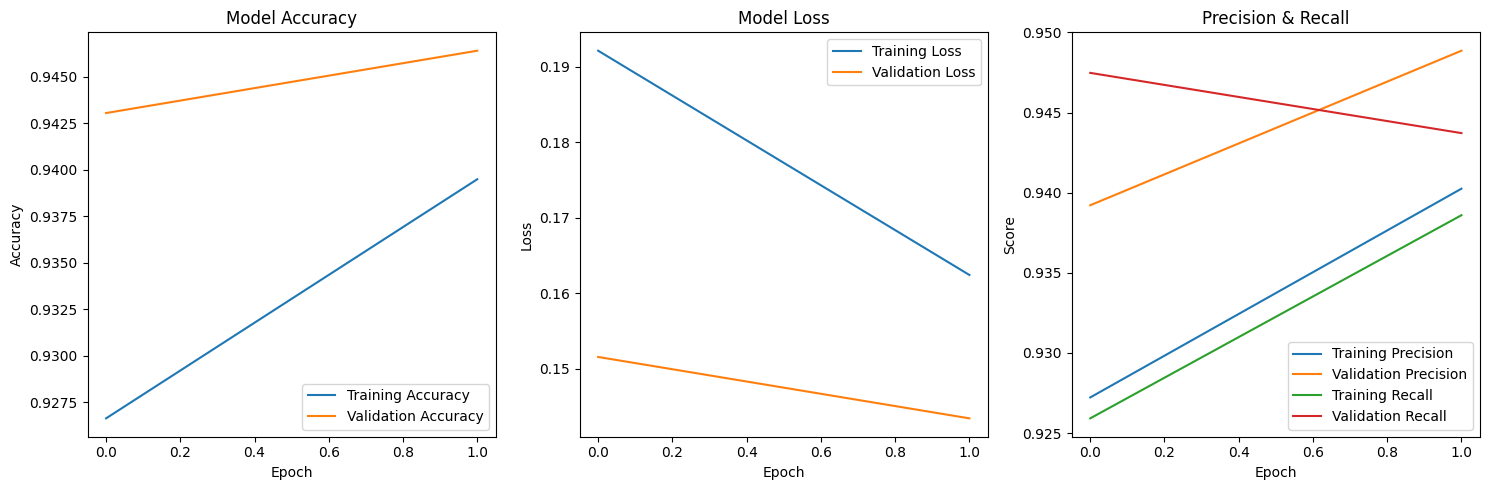

In [86]:
# Plot training history
plt.figure(figsize=(15, 5))

# 1. Plot accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 2. Plot loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 3. Plot precision and recall
plt.subplot(1, 3, 3)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Precision & Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

In [92]:
from sklearn.metrics import confusion_matrix, classification_report

In [94]:
# Make predictions
predictions = model.predict(test_texts)
predicted_classes = (predictions > 0.5).astype("int32")

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step


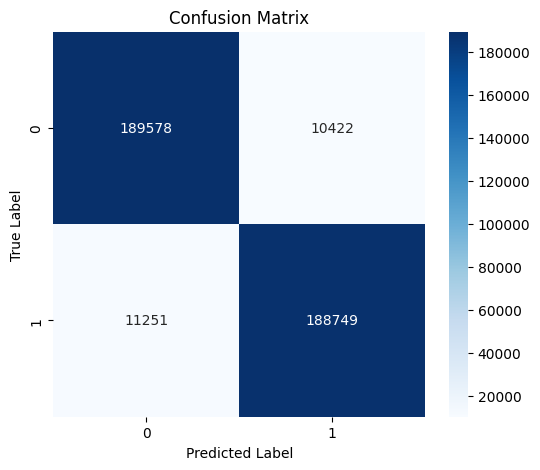

In [95]:
# Confusion matrix
cm = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [96]:
# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, predicted_classes))


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95    200000
           1       0.95      0.94      0.95    200000

    accuracy                           0.95    400000
   macro avg       0.95      0.95      0.95    400000
weighted avg       0.95      0.95      0.95    400000



## Recurrent Neural Network Model:

In [126]:
from tensorflow.keras.layers import LSTM

In [128]:
def build_rnn_model():
    embedding_dim = 100
    
    model = Sequential([
        Embedding(MAX_FEATURES, embedding_dim, input_length=MAX_LENGTH),
        LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        LSTM(32, dropout=0.2, recurrent_dropout=0.2),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    # Explicitly build the model(To show the values in model.summary())
    model.build(input_shape=(None, MAX_LENGTH))
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

rnn_model = build_rnn_model()

/opt/anaconda3/envs/py3-TF2.0/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [130]:
# Model summary
rnn_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [132]:
# Train the model
history = rnn_model.fit(
    train_texts, train_labels,
    epochs=2,
    validation_data=(val_texts, val_labels),
    batch_size=128,
    verbose=1
)

Epoch 1/2
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 7614s 338ms/step - accuracy: 0.9044 - loss: 0.2404 - precision: 0.9048 - recall: 0.9042 - val_accuracy: 0.9488 - val_loss: 0.1364 - val_precision: 0.9474 - val_recall: 0.9505
Epoch 2/2
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 7558s 336ms/step - accuracy: 0.9482 - loss: 0.1448 - precision: 0.9470 - recall: 0.9496 - val_accuracy: 0.9517 - val_loss: 0.1289 - val_precision: 0.9420 - val_recall: 0.9628


In [133]:
# Evaluate
test_loss, test_accuracy, test_precision, test_recall = rnn_model.evaluate(test_texts, test_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 350s 28ms/step - accuracy: 0.9500 - loss: 0.1346 - precision: 0.9402 - recall: 0.9619
Test Accuracy: 0.9512


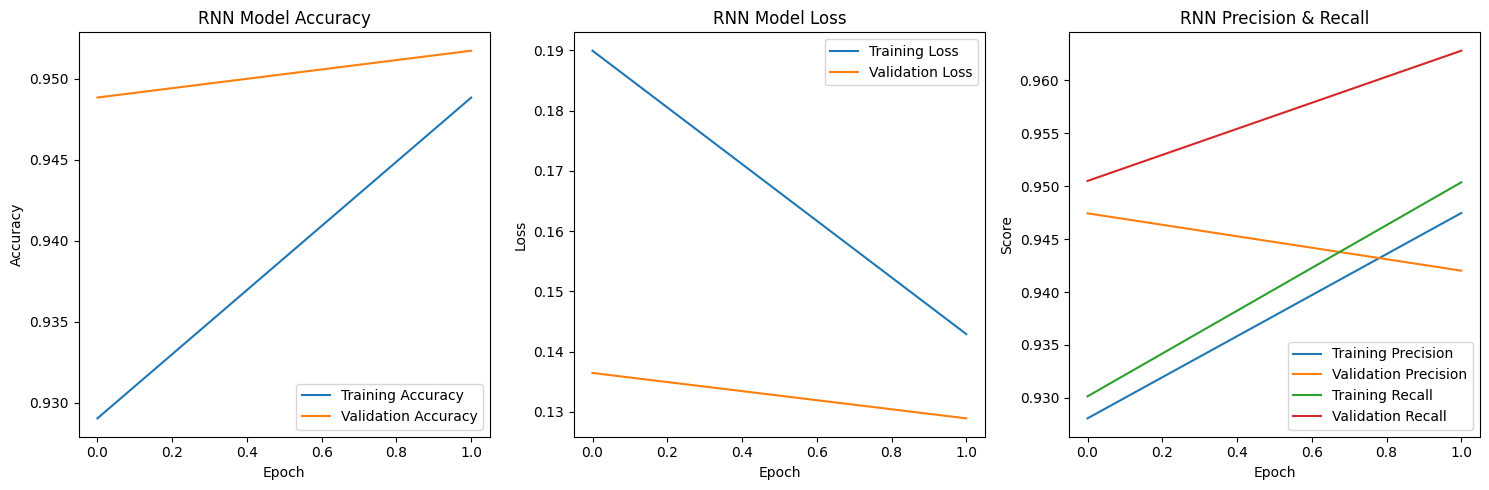

In [142]:
# Plot training history
plt.figure(figsize=(15, 5))

# 1. Plot accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('RNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 2. Plot loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('RNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 3. Plot precision and recall
plt.subplot(1, 3, 3)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('RNN Precision & Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

In [144]:
from sklearn.metrics import confusion_matrix, classification_report

In [152]:
# Make predictions
predictions = rnn_model.predict(test_texts)
predicted_classes = (predictions > 0.5).astype("int32")

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 348s 28ms/step


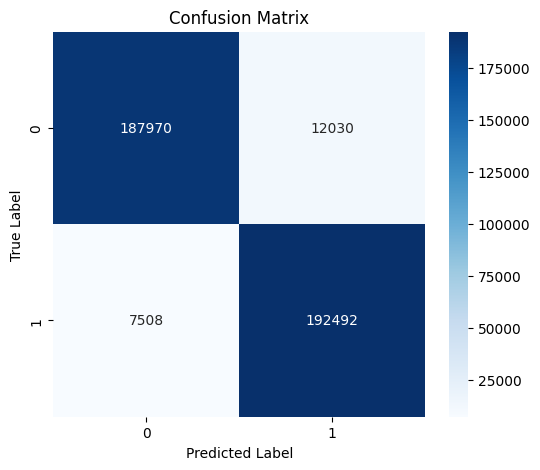

In [153]:
# Confusion matrix
cm = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [154]:
# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, predicted_classes))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95    200000
           1       0.94      0.96      0.95    200000

    accuracy                           0.95    400000
   macro avg       0.95      0.95      0.95    400000
weighted avg       0.95      0.95      0.95    400000

